In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.pandas
import datetime as dt

In [2]:
df = pd.read_csv('coffee_sales.csv')
df.head()

,transaction_id,transaction_date,transaction_time,store_id,store_location,product_id,transaction_qty,unit_price,Total_Bill,product_category,product_type,product_detail,Size,Month Name,Day Name,Hour,Month,Day of Week
0,114301,01-06-2023,11:33:29,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Thursday,11,6,3
1,115405,02-06-2023,11:18:24,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Friday,11,6,4
2,115478,02-06-2023,12:02:45,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Friday,12,6,4
3,116288,02-06-2023,19:39:47,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Friday,19,6,4
4,116714,03-06-2023,12:24:57,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Saturday,12,6,5


In [3]:
# Create a new column for the full transaction time: M/D/Y + H/M/S and convert to datetime

df['transaction_full'] = df['transaction_date'] + ' ' + df['transaction_time']
df['transaction_full'] = pd.to_datetime(df['transaction_full'],format='%d-%m-%Y %H:%M:%S')

We start our exploration by identifying which store generates the most revenue. We group the data by store location and compute the total revenue and the average total bill across each store.

In [4]:
# Group the df by store location and consider the total bill, aggregate the sum and mean of all values.

df.groupby(['store_location'])['Total_Bill'].agg(['sum','mean'])

,sum,mean
store_location,,
Astoria,232243.91,4.589891
Hell's Kitchen,236511.17,4.661696
Lower Manhattan,230057.25,4.814726


Hell's Kitchen, **HK**, generated the most revenue ($236,511.17) followed by Astoria, **A**,  ($232,243.91) and lastly Lower Manhattan, **LM**, ($230,057.25). However, the average bill was highest at LM ($4.81) vs A ($4.58) and HK ($4.66).

We could make an initial interpretation that LM generated the least revenue because their average total bill is the highest. As a result, customers are more likely to go to the other two locations because they expect to spend less on average; therefore, the other two locations generate more revenue. With this interpretation, A and HK locations would need to be analyzed more because A has a lower average total bill than HK, yet HK generates more revenue.

Let's start by investigating hourly visits to of A and HK.

In [5]:
# From this point on, we are only considering HK and A locations, so we will restrict our data frame to those locations

df_HK_A = df[(df['store_location'] == 'Astoria') | (df['store_location'] == 'Hell\'s Kitchen')]

# Density plot and Histogram plot of Hourly and Monthly visits by location

df_HK_A.hvplot.density(y='Hour',by='store_location',alpha=0.2)
# df_HK_A.hvplot.hist(y='Month',by='store_location')

:NdOverlay   [store_location]
   :Distribution   [Hour]   (Density)

We can see that both locations experience peak sales between approximately 8AM and 11AM. In this time frame, HK has a higher volume of customers. While both locations oscillate around a plateau from about noon to 7PM, Astoria maintains higher customer traffic than HK. This tells us that we should investigate what's being sold in the peak sale period (8AM-11AM) and in the plateau sale period (12PM-7PM).

The histogram of monthly visits does not depict a difference between store visits; we can ascertain that visits increase each month from February to June and decrease from January to February. It may be worth considering what is being sold in January vs February and from February to June to find a potential explanation for decrease and increase in purchases, respectively.

<AxesSubplot:title={'center':'Plateau Hours (12PM-7PM) Product Purchases by Location'}, ylabel='Product Category'>

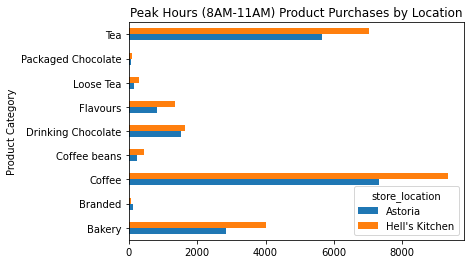

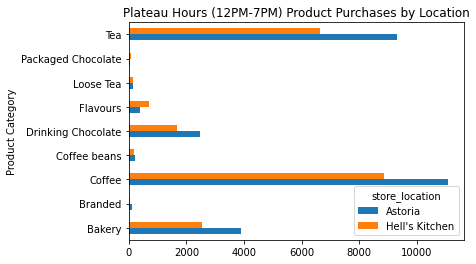

In [185]:
# The data frame is not in chronological time by transcation, so we will sort the data frame by transaction_full and store location

df_HK_A.sort_values(by=['store_location','transaction_full'])

# Create a df containing data from the peak and plateau time frames
df_peak = df_HK_A[(8 <= df_HK_A['Hour']) & (df_HK_A['Hour'] <= 11)]
df_plateau = df_HK_A[(12 <= df_HK_A['Hour']) & (df_HK_A['Hour'] <= 19)]

# Create a stacked horizontal bar graph showing categories of productc shown at A and HK

df_peak.groupby(['product_category'])['store_location'].value_counts().unstack().plot(kind='barh',
                                                                                    #   stacked='True',
                                                                                      xlabel='Product Category',
                                                                                      title='Peak Hours (8AM-11AM) Product Purchases by Location')
df_plateau.groupby(['product_category'])['store_location'].value_counts().unstack().plot(kind='barh',
                                                                                        #  stacked='True',
                                                                                         xlabel='Product Category',
                                                                                         title='Plateau Hours (12PM-7PM) Product Purchases by Location')

Our graphs does do not take into account transaction quantity; i.e. if n products are ordered in one purchase, then it's reduce to 1 product in value_counts. To account for this discrepency, we create a function that will return the augmented transaction quantities as a data frame.

In [178]:
def adjust_transaction(df):
    
    columns=['store_location','product_category','transaction_qty']
    
    temp = df[columns]
    
    temp_df = {'store_location':[],'product_category':[],'qty':[]}
    
    for x,y in temp.value_counts().groupby(['store_location','product_category','transaction_qty']):
        temp_df['store_location'].append(x[0])
        temp_df['product_category'].append(x[1])
        temp_df['qty'].append(x[2]*y[0])
        
    return pd.DataFrame(temp_df)

Now that we have our function, let's generate the new plots. Perhaps we will notice a difference besides the multiplicative increase in product type.

In [180]:
df_peak_adjust = adjust_transaction(df_peak)
df_plateau_adjust = adjust_transaction(df_plateau)

We comment out stacking to see each bar graph side-by-side for an easier comparison; however, when looking at both in full to compare, uncomment stacked.

<AxesSubplot:title={'center':'Peak Hours (8AM-11AM) Product Purchases by Location'}, ylabel='Product Category'>

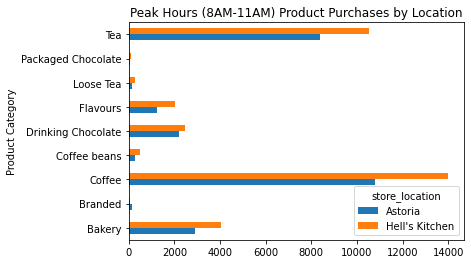

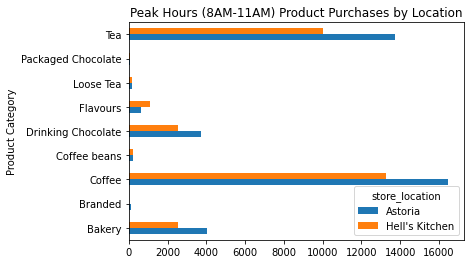

In [184]:
df_peak_adjust.groupby(['product_category','store_location'])['qty'].sum().unstack().plot(kind='barh',
                                                                                        #   stacked='True',
                                                                                          xlabel='Product Category',
                                                                                          title='Peak Hours (8AM-11AM) Product Purchases by Location')

df_plateau_adjust.groupby(['product_category','store_location'])['qty'].sum().unstack().plot(kind='barh',
                                                                                            #  stacked='True',
                                                                                             xlabel='Product Category',
                                                                                             title='Peak Hours (8AM-11AM) Product Purchases by Location')

Observe that our bar graphs look similar; However, the x-axis labels are increased after adjustment to account for multiple orders. This is an example of data visualization demonstrating the same graphic, however, if we were to analyze this data without visuals, we'd have discrepencies. For example, reading the bar graph in cell [6], we would believe that HK sold approximately 7000 units of tea when in reality HK sold approximately 11000 units of tea, per cell [9].

Okay! So we've explored and played with our data a bit, now let's see if we can answer a question that the coffee business may have: The coffee shop is looking to introduce a special new drink for the month of July! The coffee shop has the following questions:


1. What kind of product should we create for our special drink? (I.e. what category of product, what type of product, what flavor of product)?
2. Should we feature this product at all three locations? If no, what are the top two (2) locations for product placement?
3. What is a reasonable unit price for the special drink?
4. If we offer a promotion, what are some feasible days and times for promotion? For example: some College town bars frequently have a Thirsty Thursday special, or some Taco locations have a Taco Tuesday or Margarita Wednesday deal.

In [83]:
df_peak

,transaction_id,transaction_date,transaction_time,store_id,store_location,product_id,transaction_qty,unit_price,Total_Bill,product_category,product_type,product_detail,Size,Month Name,Day Name,Hour,Month,Day of Week,transaction_full
0,114301,01-06-2023,11:33:29,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Thursday,11,6,3,2023-06-01 11:33:29
1,115405,02-06-2023,11:18:24,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Friday,11,6,4,2023-06-02 11:18:24
17,121279,07-06-2023,10:16:40,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Wednesday,10,6,2,2023-06-07 10:16:40
18,121416,07-06-2023,10:59:19,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Wednesday,10,6,2,2023-06-07 10:59:19
23,122518,08-06-2023,11:09:47,3,Astoria,45,1,3.0,3.0,Tea,Brewed herbal tea,Peppermint,Large,June,Thursday,11,6,3,2023-06-08 11:09:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149104,98529,17-05-2023,11:18:31,8,Hell's Kitchen,8,8,45.0,360.0,Coffee beans,Premium Beans,Civet Cat,Not Defined,May,Wednesday,11,5,2,2023-05-17 11:18:31
149112,133523,17-06-2023,09:55:47,8,Hell's Kitchen,8,8,45.0,360.0,Coffee beans,Premium Beans,Civet Cat,Not Defined,June,Saturday,9,6,5,2023-06-17 09:55:47
149113,133674,17-06-2023,10:41:11,8,Hell's Kitchen,8,8,45.0,360.0,Coffee beans,Premium Beans,Civet Cat,Not Defined,June,Saturday,10,6,5,2023-06-17 10:41:11
149114,133744,17-06-2023,11:18:31,8,Hell's Kitchen,8,8,45.0,360.0,Coffee beans,Premium Beans,Civet Cat,Not Defined,June,Saturday,11,6,5,2023-06-17 11:18:31
